This is a short project examining how different technical indicators for trading and how well they worked recently and in the past (Exercise 2). I have decided to focus on the 5 tech company stocks (Apple, Nvidia, Microsoft, Google, Amazon) with my analysis. I will be using the ta library in python for the different technical indicators. I will compare how these indicators peform in a year long time window (2023-2024) and compare this a year in the past (2013-2014).

In [1]:
import yfinance as yf # for retrieving financial data
import pandas as pd # for data analysis
import numpy as np  # for math
import matplotlib.pyplot as plt # for plotting graphs
import ta # for indicators
from IPython.display import display # to display pandas dataframes in a nice way

In [2]:
# function to get open high low close data for a given ticker, start and end date.
def get_ohlc(ticker, start, end):
    return yf.download(ticker, start=start, end=end)
    
# tickers I will be using.
tickers = ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'AMZN'] 

example_df = get_ohlc('AAPL', start='2019-01-01', end='2019-01-5')

ohlc_present = {ticker : get_ohlc(ticker, '2023-01-01', '2024-01-01') for ticker in tickers}

ohlc_past = {ticker : get_ohlc(ticker, '2013-01-01', '2014-01-01') for ticker in tickers}



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


I implement 3 different strategies below. Brief descriptions of them:

Bollinger bands - Take a rolling average (for example with a window of size 20)
Plot two bands, one is the rolling average plus a multiple of the standard deviation of the prices, the other is the rolling average minus the same value. When the prices exceeds the upper band we sell as we expect the price to go back down. Similarly when the price goes below the lowet band we buy as we expect the price to go back up.

RSI (Relative Strength Index) Strategy - The RSI is a measure of price movement, and can be used to detect when an asset is overbought or oversold. We use this to buy when oversold and sell when overbought to make a profit.

Simple Moving Average Crossover - uses two moving averages of different windows as an indicator for when to buy/sell



In [3]:
# FIRST STRAT - BOLLINGER BANDS

def bollinger_strat(df):

    df['ma_20'] = df.Close.rolling(20).mean()
    df['vol'] = df.Close.rolling(20).std()
    # bollinger bands
    s = 2 # how many standard deviations our bands are away from the moving average
    df['upper_bb'] = df['ma_20'] + s * df['vol']
    df['lower_bb'] = df['ma_20'] - s * df['vol']

    conditions = [(df.Close < df.lower_bb), (df.Close > df.upper_bb)]
    choices = ['Buy', 'Sell']

    df['signal'] = np.select(conditions, choices, '0')
    df.dropna(inplace=True)

    df.signal = df.signal.shift() # shift signals 1 forward as we can only trade on next days open
    df['shifted_Close'] = df.Close.shift()


bollinger_strat(ohlc_present['AAPL'])

ohlc_present['AAPL'][ohlc_present['AAPL']['signal']=='Buy']


,Open,High,Low,Close,Adj Close,Volume,ma_20,vol,upper_bb,lower_bb,signal,shifted_Close
Date,,,,,,,,,,,,
2023-08-07,182.130005,183.130005,177.350006,178.850006,177.699509,97576100,191.677001,4.427904,200.532810,182.821193,Buy,181.990005
2023-08-08,179.690002,180.270004,177.580002,179.800003,178.643372,67823000,191.263001,5.115596,201.494193,181.031809,Buy,178.850006
2023-08-09,180.869995,180.929993,177.009995,178.190002,177.043762,60378500,190.684001,5.890164,202.464329,178.903673,Buy,179.800003
2023-08-10,179.479996,180.750000,177.600006,177.970001,176.825165,54686900,190.055502,6.541010,203.137521,176.973482,Buy,178.190002
2023-10-27,166.910004,168.960007,166.830002,168.220001,167.363586,58499100,175.082502,3.778928,182.640359,167.524645,Buy,166.889999


In [37]:
# SECOND STRAT - RSI

def rsi_strat(df):
    df['rsi'] = ta.momentum.rsi(df.Close, window=6)

    conditions = [(df.rsi < 30), (df.rsi > 70)]
    choices = ['Buy', 'Sell']

    df['signal'] = np.select(conditions, choices, '0')

    df.dropna(inplace=True)
    df.dropna()
    df.signal = df.signal.shift() 
    df['shifted_Close'] = df.Close.shift()

In [21]:
# THIRD STRAT - SIMPLE MOVING AVERAGE CROSSOVER START

def sma_crossover_strat(df):
    df['SMA50'] = df['Close'].rolling(window=10).mean() # short window
    df['SMA200'] = df['Close'].rolling(window=50).mean() # long window

    df['crosses'] = df['SMA50'] > df['SMA200']
    df['position'] = df['crosses'].diff() 

    conditions = [df.position == 0, df.position == 1]
    choices = ['Buy', 'Sell']
    df['signal'] = np.select(conditions, choices, '0')

    df.dropna(inplace=True)
    df.signal = df.signal.shift() 
    df['shifted_Close'] = df.Close.shift()



{'AAPL': -0.03999059776058966,
 'MSFT': 0.192267263307768,
 'GOOGL': 0.18120796632512803,
 'NVDA': 0.15348786433525463,
 'AMZN': 0.22020864161743225}

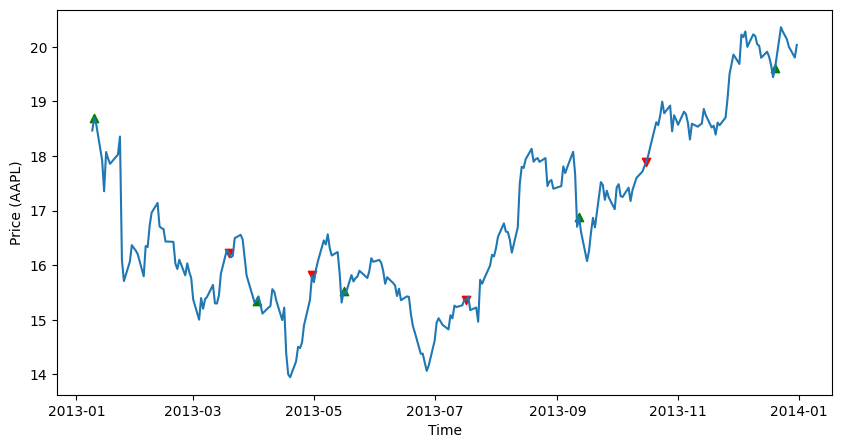

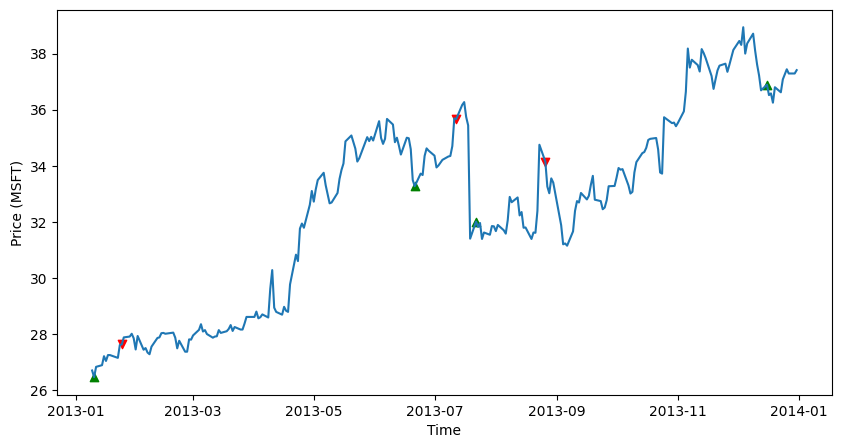

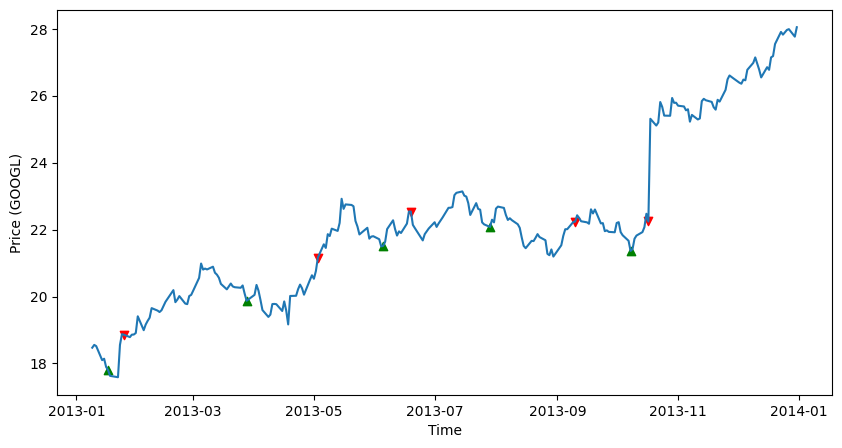

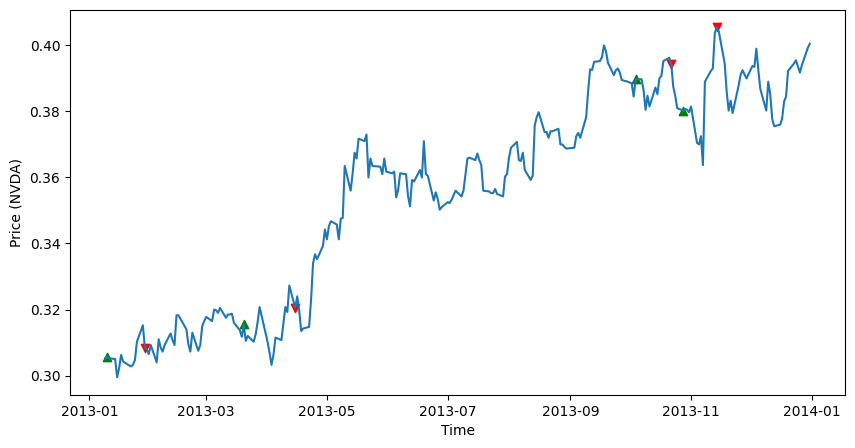

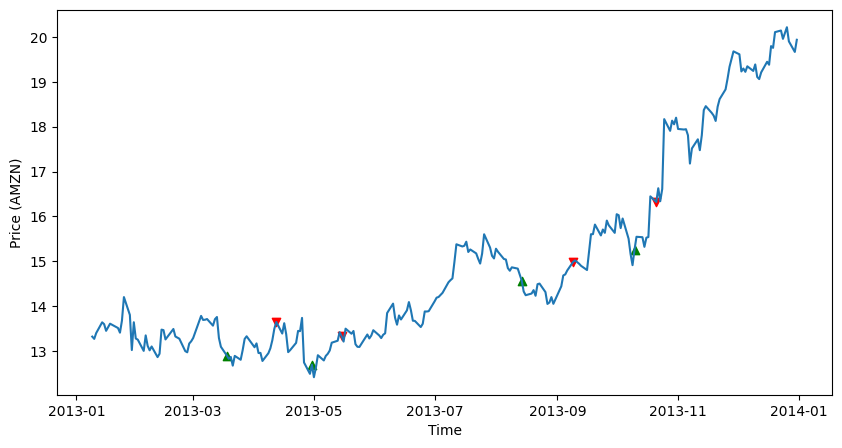

In [55]:

# this function takes in a strategy (which is a function) and backtests it
def backtester(strat, ohlc, show_graphs=False):

    results = {}

    for ticker in tickers:
        df = ohlc[ticker].copy()
        strat(df)
        position = False # used to check if we currently hold a position

        buydates, selldates = [], []
        buyprices, sellprices = [], []

        for index, row in df.iterrows():
            if not position and row['signal'] == 'Buy':
                buydates.append(index)
                buyprices.append(row.Open)
                position = True
            
            # can optionally use a stoploss to be less risky with our trades
            stoploss = False #row.shifted_Close < 0.7 * buyprices[-1] 
            if position and (row['signal'] == 'Sell' or stoploss):
                selldates.append(index)
                sellprices.append(row.Open)
                position = False

        returns = (1+pd.Series([(sell - buy) / buy for sell, buy in zip(sellprices, buyprices)])).prod()-1
        results[ticker] = returns
        
        if show_graphs:
            # plot closing price and buy/sell signals
            plt.figure(figsize=(10, 5))
            plt.plot(df.Close)
            plt.xlabel("Time")
            plt.ylabel(f"Price ({ticker})")
            plt.scatter(df.loc[buydates].index, df.loc[buydates].Close, marker = '^', c='g')
            plt.scatter(df.loc[selldates].index, df.loc[selldates].Close, marker = 'v', c='r')
    
    
    return results

# an example of how to use backtester
backtester(rsi_strat, ohlc_past, show_graphs=True)

In [54]:
# display results

strats = [bollinger_strat, sma_crossover_strat, rsi_strat]


present = [] # stores mean returns of each strat on present data

for strat in strats:
    results = backtester(strat, ohlc_present)
    present.append(np.mean(list(results.values())))

past = [] # stores mean returns of each strat on past data

for strat in strats:
    results = backtester(strat, ohlc_past)
    past.append(np.mean(list(results.values())))


print(present)
print(past)

[0.1688423714070796, 0.4125934716773207, 0.2446024114225062]
[0.18377750195123338, 0.2373079732213653, 0.14143622756499866]


Results

I implemented 3 different trading strategies based on different indicators and tested them on two one year time periods, a recent one and less recent one. I did this to compare how well the technical indicators work nowaways compared to a time in the past. 

Running the results function gives us the following returns:

Present Data (2023-2024)


Backtesting the bollinger_strat strategy:
Returns for AAPL : 0.158283621513452
Returns for MSFT : 0.09411425800690854
Returns for GOOGL : 0.2313302931966077
Returns for NVDA : 0.1632827062562754
Returns for AMZN : 0.19720097806215442


Backtesting the sma_crossover_strat strategy:
Returns for AAPL : 0.12956163734614345
Returns for MSFT : 0.22021473182308804
Returns for GOOGL : 0.3340689134028014
Returns for NVDA : 0.9202783651273112
Returns for AMZN : 0.4588437106872596


Backtesting the rsi_strat strategy:
Returns for AAPL : 0.16343429058059322
Returns for MSFT : 0.16837292038797735
Returns for GOOGL : 0.46094344635049733
Returns for NVDA : 0.31995953269427346
Returns for AMZN : 0.11030186709918954


Past Data (2013-2014)


Backtesting the bollinger_strat strategy:
Returns for AAPL : 0.16617073672703309
Returns for MSFT : 0.14707296885165766
Returns for GOOGL : 0.33571878711053627
Returns for NVDA : 0.06443719357207156
Returns for AMZN : 0.20548782349486827


Backtesting the sma_crossover_strat strategy:
Returns for AAPL : 0.09170248087355648
Returns for MSFT : 0.35125574798328674
Returns for GOOGL : 0.23411313094077624
Returns for NVDA : 0.3619070987314099
Returns for AMZN : 0.14756140757779712


Backtesting the rsi_strat strategy:
Returns for AAPL : -0.03999059776058966
Returns for MSFT : 0.192267263307768
Returns for GOOGL : 0.18120796632512803
Returns for NVDA : 0.15348786433525463
Returns for AMZN : 0.22020864161743225

Some further analysis (which can be seen in previous code) shows that, on average, the strategies performed better in the past than in the recent data. This suggests that these indicators might be more risky now than 10 years ago. 

We also see that, on average, the simple moving average cross over strategy appears to perform the best, averaging returns of 40 percent on the past data and 20 percent on the present data. To get a feel for how this cross over strategy we can plot a graph, which shows the crossing overs between the long and short term averages:

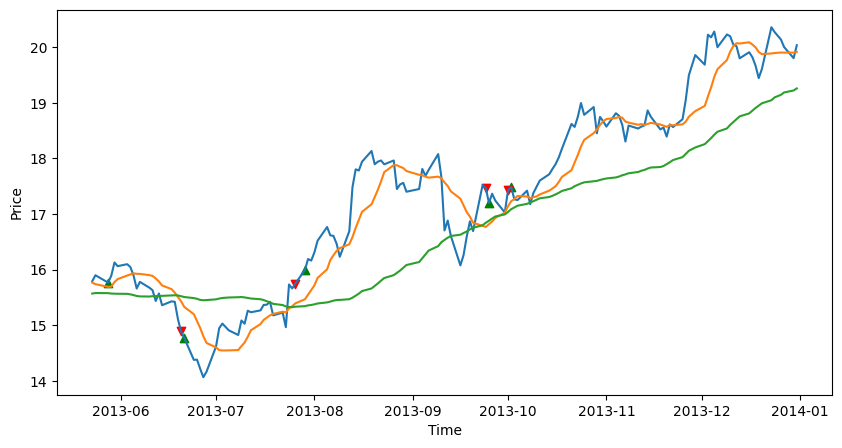

In [64]:
df = ohlc_past['AAPL'].copy()
sma_crossover_strat(df)
position = False # used to check if we currently hold a position

buydates, selldates = [], []
buyprices, sellprices = [], []

for index, row in df.iterrows():
    if not position and row['signal'] == 'Buy':
        buydates.append(index)
        buyprices.append(row.Open)
        position = True
    
    # can optionally use a stoploss to be less risky with our trades
    stoploss = False #row.shifted_Close < 0.7 * buyprices[-1] 
    if position and (row['signal'] == 'Sell' or stoploss):
        selldates.append(index)
        sellprices.append(row.Open)
        position = False

plt.figure(figsize=(10, 5))
plt.plot(df.Close)

plt.scatter(df.loc[buydates].index, df.loc[buydates].Close, marker = '^', c='g')
plt.scatter(df.loc[selldates].index, df.loc[selldates].Close, marker = 'v', c='r')
plt.xlabel("Time")
plt.ylabel(f"Price")
plt.plot(df['SMA50'], label='50-day SMA')
plt.plot(df['SMA200'], label='200-day SMA')



In summary, we saw that the strategies we tested performed better in the past than a more recent time period. 

If I had more time, I would experiment with different time periods to gather more evidence that suggests the performance of these technical indicators being better in the past. It is also important to note that the strategies can be combined, which could be successful as using several indicators to inform your trades means you have more information can might make less riskier trades overall. 

Another point is that with these strategies you can add a stop loss, so that when an asset you have bought drops below a threshold, you sell it. An interesting idea would be to explore how adjusting this threshold affects the performance of the strategies. 

My analysis was restricted to technology companies given the time limit. Testing these indicators on a large range of asset classes would allow us to get a bigger picture of how each strategy performs. 

And finally, there are of course many other indicators worth exploring. 
